# Introduction

In this tutorial, we implement kernels designed in Automatic forecasting using Gaussian Process [1] and test results with the M3 dataset.



# Data loading and visualization
The data is available at the following path.

In [89]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import gpytorch as gp
import random

random.seed(0)
df = pd.read_csv('/mnt/persistent-public/zhencao/M3_monthly_TSTS.csv')
df

,series_id,category,value,timestamp
0,M1,MICRO,2640.0,1990-01
1,M1,MICRO,2640.0,1990-02
2,M1,MICRO,2160.0,1990-03
3,M1,MICRO,4200.0,1990-04
4,M1,MICRO,3360.0,1990-05
...,...,...,...,...
167557,M1428,OTHER,1282.5,NaN
167558,M1428,OTHER,1261.3,NaN
167559,M1428,OTHER,1263.4,NaN
167560,M1428,OTHER,1257.1,NaN


Select series_id for one product, and we'll fit GP as a univariate model.

In [90]:
series_id = 'M10'
num_test = 18
df = df[df['series_id']==series_id]
df

,series_id,category,value,timestamp
612,M10,MICRO,4120.0,1990-01
613,M10,MICRO,5020.0,1990-02
614,M10,MICRO,3840.0,1990-03
615,M10,MICRO,5720.0,1990-04
616,M10,MICRO,4960.0,1990-05
...,...,...,...,...
675,M10,MICRO,3820.0,1995-04
676,M10,MICRO,4880.0,1995-05
677,M10,MICRO,2800.0,1995-06
678,M10,MICRO,3640.0,1995-07


## Plotting the data with time
We visualize the data of one product in M3 in time series.

<ipython-input-91-36445822154e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'value')

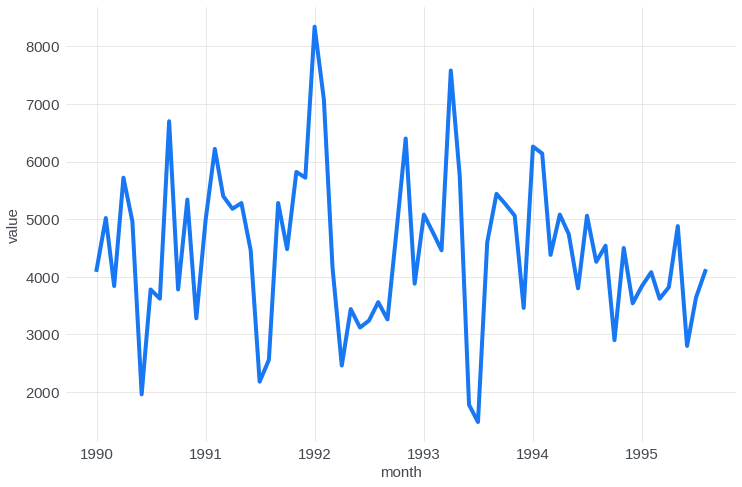

In [91]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
plt.rcParams['figure.figsize'] = 12, 8
sns.lineplot(x='timestamp', y='value', data=df)
plt.xlabel('month')
plt.ylabel('value')


## Plotting the auto-correlation
We plot the auto correlcation function below.

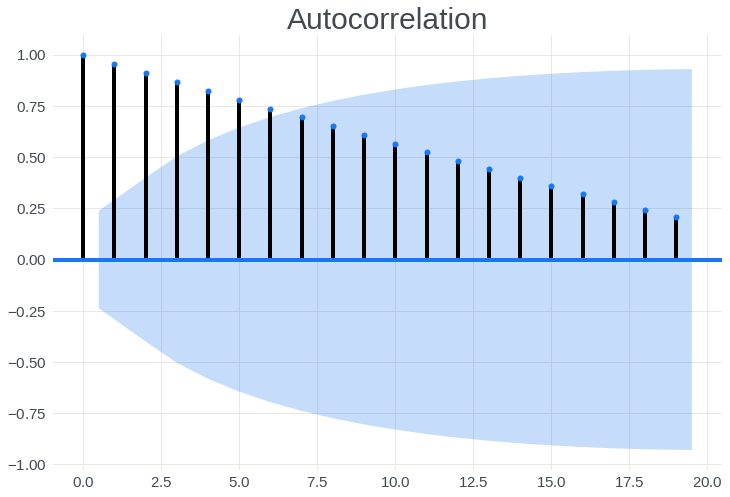

In [92]:
from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(df['timestamp'])

## Data transformation
We prepare the training set and test set data with normalizaton.

In [93]:
from sts.data import df_to_tensor

df_convert_fns = {
    'timestamp': lambda x: (x - x.iloc[0]).dt.days
}

df['log_value'] = np.log(df['value'])
df = df[['timestamp','value','log_value']]

data = df_to_tensor(df, normalize_cols=True, df_convert_fns=df_convert_fns)
num_trainset = len(df)-num_test
x_train = data[:num_trainset, ['timestamp']]
y_train = data[:num_trainset, 'log_value']
x_test = data[num_trainset:, ['timestamp']]
y_test = data[num_trainset:, 'value']


<ipython-input-93-8b406d95bae0>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
from sts.gp.model import AdditiveSpectralMixtureTimeSeriesExactGPModel
from sts.gp.kernel import WhiteNoiseKernel
from gpytorch.kernels import LinearKernel, RBFKernel

likelihood = gp.likelihoods.GaussianLikelihood()
model = AdditiveSpectralMixtureTimeSeriesExactGPModel(x_train, y_train, likelihood)
model.cov.add_seasonality(
            time_axis="timestamp", period_length=365.25, fix_period=True
        )
model.cov.add_trend(
    time_axis="timestamp", kernel_cls=LinearKernel, name="LinearTrend"
)
model.cov.add_trend(
    time_axis="timestamp",
    kernel_cls=RBFKernel,
    lengthscale=100,
    fix_lengthscale=True,
    name="RBFTrend",
)
model.cov.add_spectral_mixture(
    time_axis="timestamp",
    num_mixtures=2,
    train_x=x_train.tensor,
    train_y=y_train.tensor,
    name="SM1",
)
model.cov.add_spectral_mixture(
    time_axis="timestamp",
    num_mixtures=2,
    train_x=x_train.tensor,
    train_y=y_train.tensor,
    name="SM2",
)


# Training loop
We train our model with our training set, and show the training time below.

In [95]:
learning_rate = 0.01
num_epochs = 3000
trainer = model.train_init(torch.optim.Adam(model.trainable_params, lr=learning_rate))

def train():
    for epoch in range(num_epochs):
        loss = trainer(x_train, y_train)
        if (epoch + 1) % 200 == 1:
            print(f'epoch {epoch+1}/{num_epochs}, loss {loss}')

%time train()

/mnt/xarfuse/uid-353778/4490d57c-seed-nspid4026531836_cgpid99683980-ns-4026531840/gpytorch/utils/cholesky.py:44: NumericalWarning:

A not p.d., added jitter of 1.0e-06 to the diagonal

/mnt/xarfuse/uid-353778/4490d57c-seed-nspid4026531836_cgpid99683980-ns-4026531840/gpytorch/utils/cholesky.py:44: NumericalWarning:

A not p.d., added jitter of 1.0e-05 to the diagonal



epoch 1/3000, loss 1.696009874343872


epoch 201/3000, loss 1.3974676132202148


epoch 401/3000, loss 1.2631440162658691


epoch 601/3000, loss 1.2498987913131714


epoch 801/3000, loss 1.247230887413025


epoch 1001/3000, loss 1.2462594509124756


epoch 1201/3000, loss 1.2457836866378784


epoch 1401/3000, loss 1.2451318502426147


epoch 1601/3000, loss 1.2099428176879883


epoch 1801/3000, loss 1.1965670585632324


epoch 2001/3000, loss 1.195930004119873


epoch 2201/3000, loss 1.195489764213562


epoch 2401/3000, loss 1.1951385736465454


epoch 2601/3000, loss 1.1948914527893066


epoch 2801/3000, loss 1.1947181224822998


CPU times: user 7min 44s, sys: 4min 58s, total: 12min 42s
Wall time: 35.3 s


# Predictions
We use our model to forecast the test set.



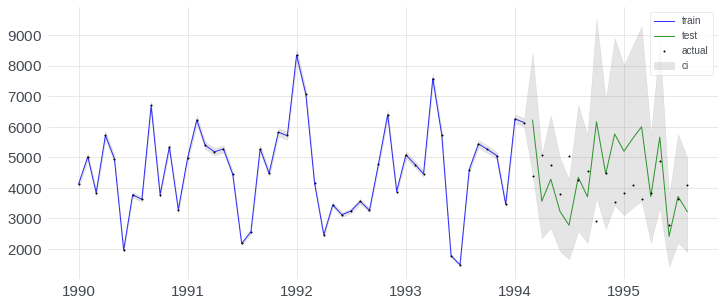

In [96]:
from sts.data import get_mvn_stats
from torch.distributions import ComposeTransform, ExpTransform

transform = ComposeTransform([y_train.transforms['log_value'].inv, ExpTransform()])
train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train), transform)
test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test), transform)

f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(df['timestamp'][:num_trainset], train_mean, alpha=0.8, color='blue', linewidth=1, label='train')
ax.plot(df['timestamp'][num_trainset:], test_mean, alpha=0.8, color='green', linewidth=1, label='test')
ax.plot(df['timestamp'], df['value'], 'o', markersize=1, color='black', label='actual')
ax.fill_between(df['timestamp'], torch.cat([train_ci[0], test_ci[0]]), torch.cat([train_ci[1], test_ci[1]]), alpha=0.2, label='ci', color='gray')
ax.legend()


The training set has tight credible intervals, while that of the test set is wider. This makes sense since the credible interval gets larger if we extrapolate from the data. But still, we would like to see better performance in the forecasting part.


# Kernel Decomposition
We decompose additive kernels to see how each kernel functions.

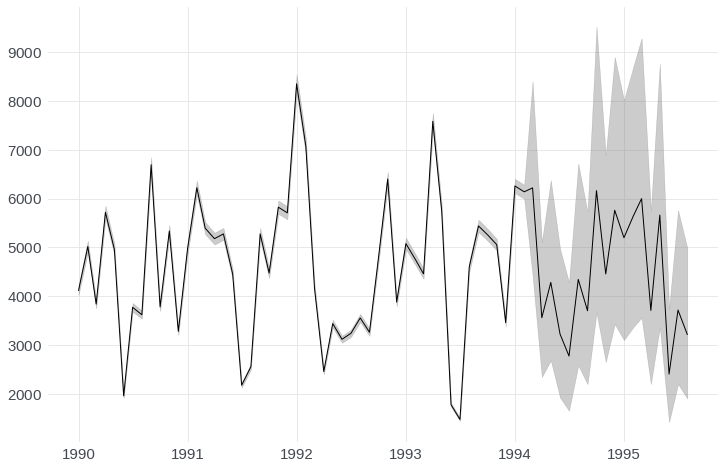

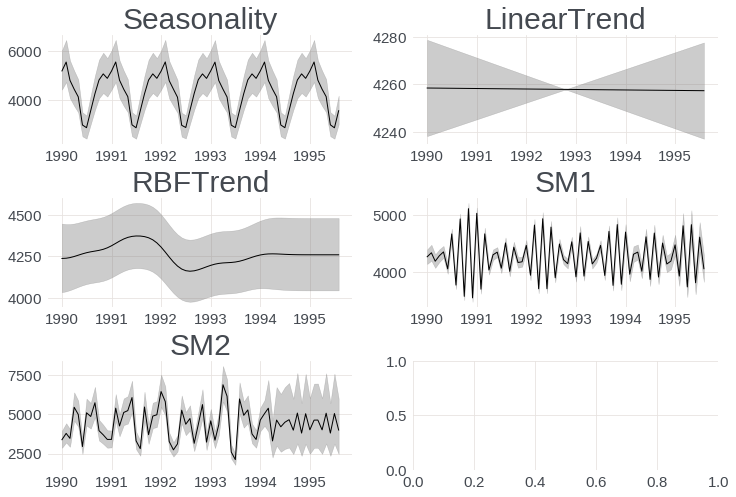

In [97]:
from sts.gp.graph import plot_components

x_all = torch.cat([x_train.tensor, x_test.tensor])
components = model.decompose_timeseries(x_all)
fig, ax = plot_components(df['timestamp'], components[1], y=model.predict(x_all), transform=transform)

# Evaluation
We measure mean absolute error (MAE), continuous-ranked probability score (CRPS), and log-likelihood (LL) using normalized values on both of the training set and the test set.

In [98]:
train_mean, train_var, train_ci = get_mvn_stats(model.predict(x_train))
test_mean, test_var, test_ci = get_mvn_stats(model.predict(x_test))


Here we compute MAE for both training data and test data.

In [99]:
from sts.metrics import MAE
MAE_train = MAE(y_train.tensor, train_mean).item()
MAE_test = MAE(y_test.tensor, test_mean).item()
print(f'Mean absolute error for training set is: {MAE_train:.3f}')
print(f'Mean absolute error for test set is: {MAE_test:.3f}')

Mean absolute error for training set is: 0.002
Mean absolute error for test set is: 0.813


Here we compute CRPS for both training data and test data.

In [100]:
from sts.crps import crps_gaussian
crps_train = crps_gaussian(y_train.tensor, train_mean, train_var.sqrt())
crps_test = crps_gaussian(y_test.tensor, test_mean, test_var.sqrt())
print(f'Continuous ranked probability score for training set is: {crps_train.mean().item():.3f}')
print(f'Continuous ranked probability score for test set is: {crps_test.mean().item():.3f}')

Continuous ranked probability score for training set is: 0.010
Continuous ranked probability score for test set is: 0.596


Here we compute log-likelihood for both training data and test data.



In [101]:
from sts.metrics import log_likelihood_error
ll_train = log_likelihood_error(train_mean, y_train.tensor, train_var).item()
ll_test = log_likelihood_error(test_mean, y_test.tensor, test_var).item()
print(f'Log-likelihood for training set is: {ll_train:.3f}')
print(f'Log-likelihood for test set is: {ll_test:.3f}')

Log-likelihood for training set is: 2.231
Log-likelihood for test set is: -1.517


In [102]:
scores = [[MAE_train, crps_train.mean().item(), ll_train], [MAE_test, crps_test.mean().item(), ll_test]]
df_meature = pd.DataFrame(scores, columns = ['MAE', 'CPRS', 'LL'])
df_meature

,MAE,CPRS,LL
0,0.001731,0.010051,2.230578
1,0.812689,0.596490,-1.516943


Above is the table showing the values of each metrics, where the first line is for the training set and the second line is for the test set. As a kind reminder, MAE and CRPS are better if they are lower, while LL is better when it's higher.


At the same time, we noticed the training set shows higher accuracy than the test set. To improve this, we will assign priors to the hyperparameters and use the hierarchical priors to gain joint information of univarite time series.

# References

[1] Corani, G., Benavoli, A., Augusto, J. and Zaffalon, M., 2020. Automatic Forecasting using Gaussian Processes. arXiv preprint arXiv:2009.08102.